Authors:

Nathen Hale Fernandes

Alexander Armstrong

Marc Crasto

For model training, optimization, and evaluation, we used a combination of libraries. Scikit-learn was the primary library for building and evaluating machine learning models, leveraging its comprehensive tools for classification and performance metrics. Skopt facilitated the Bayesian Optimization process, optimizing hyperparameters efficiently. For visualizing data and results, Matplotlib was utilized to create informative plots and graphs.

In [231]:
#Libraries
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder

from sklearn.feature_selection import mutual_info_classif

from sklearn.feature_selection import RFECV
from xgboost import XGBClassifier

#For the cross-validation
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz
from skopt import BayesSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score

DATA PREPROCESSING

Our data preprocessing pipeline consisted of three key stages: feature creation, data cleaning, and feature selection.

Before we enter the feature creation stage, we modify the 'Collisions.csv' dataset a bit. First we replace SEVERITYCODE that have '2b' as their value to 3. Technically, this should happen in the data cleaning stage, but we ran into errors when we did it there, so we did it right at the start. Then we convert a few categorical variables to numberical values. Some of the categorical variables that had NaN as their value were replaced with 0. Then, we saved the new dataframe as 'Modified_Collisions.csv'. This was done as there were some errors being thrown when dealing with the 'Collisions.csv' file directly

In [232]:
csv_file_path = 'Collisions.csv'
new_csv_file_path = 'Modified_Collisions.csv'

df = pd.read_csv(csv_file_path)

# Consolidate '2b' and '3' under one class
df['SEVERITYCODE'] = df['SEVERITYCODE'].replace({'2b': 3})

# Convert to numerical data and fill missing values wherever required
df['UNDERINFL'] = df['UNDERINFL'].replace({'N': 0, 'Y': 1})
df['INATTENTIONIND'] = df['INATTENTIONIND'].replace({'N': 0, 'Y': 1})
df['SPEEDING'] = df['SPEEDING'].replace({'N': 0, 'Y': 1})
df['UNDERINFL'] = pd.to_numeric(df['UNDERINFL'], errors='coerce').fillna(0).astype(int)
df['INATTENTIONIND'] = pd.to_numeric(df['INATTENTIONIND'], errors='coerce').fillna(0).astype(int)
df['SPEEDING'] = pd.to_numeric(df['SPEEDING'], errors='coerce').fillna(0).astype(int)

# Save the dataframe as a new .csv file
df.to_csv(new_csv_file_path, index=False)

Now we move to the first stage of the pipeline process. In feature creation, we developed High-Risk Driver and Environmental Risk features to enhance predictive accuracy. The High-Risk Driver score integrates data on driver distractions (INATTENTIONIND) or intoxicated (UNDERINFL). Another feature that we came up with is the Environmental Risk score which accounts for weather (WEATHER) and visibility conditions (LIGHTCOND). Recognizing the impact of temporal patterns on traffic accidents, we also introduced two new features: Season (categorizing incidents into Spring, Summer, Fall, or Winter) and Weekday (labeling days from Sunday to Saturday). These features provided valuable contextual information, significantly improving the models' predictive performance.

In [233]:
# Load the new .csv file into a dataframe
df = pd.read_csv('Modified_Collisions.csv')

# Create the High_Risk_Driver feature
df['High_Risk_Driver'] = df['INATTENTIONIND'] + df['UNDERINFL']

# Create Environmental_Risk by incorporating risk scores from weather, road conditions, and visibility (light conditions). Below are the mappings.
weather_risk = {'Clear': 1, 'Overcast': 2, 'Raining': 3, 'Fog/Smog': 4, 'Other': 2, 'Unknown':1}
roadcond_risk = {'Dry': 1, 'Wet': 2, 'Standing Water': 3, 'Snow/Slush': 4, 'Ice': 5, 'Other': 2, 'Unknown': 1}
visibility_risk = {'Daylight': 1, 'Dawn': 2, 'Dusk': 3, 'Dark - Street Lights On': 4, 'Dark - No Street Lights': 5, 'Unknown': 1}

# Add up the scores to create Environmental_Risk
df['Environmental_Risk'] = df['WEATHER'].map(weather_risk) + df['LIGHTCOND'].map(visibility_risk) + df['ROADCOND'].map(roadcond_risk)

The heatmap below shows accidents peak in summer, suggesting seasonal patterns

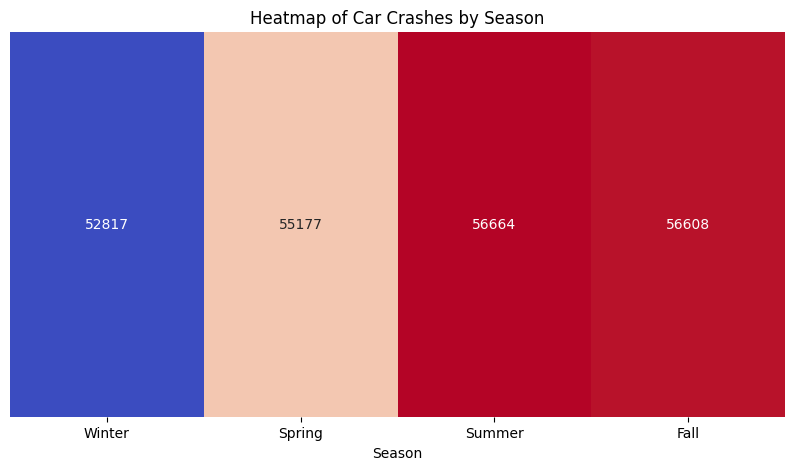

In [234]:
# Create the Season and Weekday features.
# First convert INCDATE to datetime format
df['INCDATE'] = pd.to_datetime(df['INCDATE'])

# Extract Month from INCDATE
df['Month'] = df['INCDATE'].dt.month

# Below are the season mappings corresponding to the month
season_mapping = {
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Fall', 10: 'Fall', 11: 'Fall'
}

# Create Season Feature
df['Season'] = df['Month'].map(season_mapping)

# Aggregate the data to count crashes by season
crash_counts = df['Season'].value_counts().reindex(['Winter', 'Spring', 'Summer', 'Fall']).fillna(0)

# Create a heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(crash_counts.values.reshape(1, -1), cmap='coolwarm', annot=True, fmt='g', cbar=False)
plt.title('Heatmap of Car Crashes by Season')
plt.xlabel('Season')
plt.yticks([])
plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=['Winter', 'Spring', 'Summer', 'Fall'], rotation=0)
plt.show()

The heatmap below shows the number of accidents occurring on each day of the week. It reveals a notable trend, with accidents being more frequent on Fridays, indicating a possible correlation between the day of the week and the number of accidents

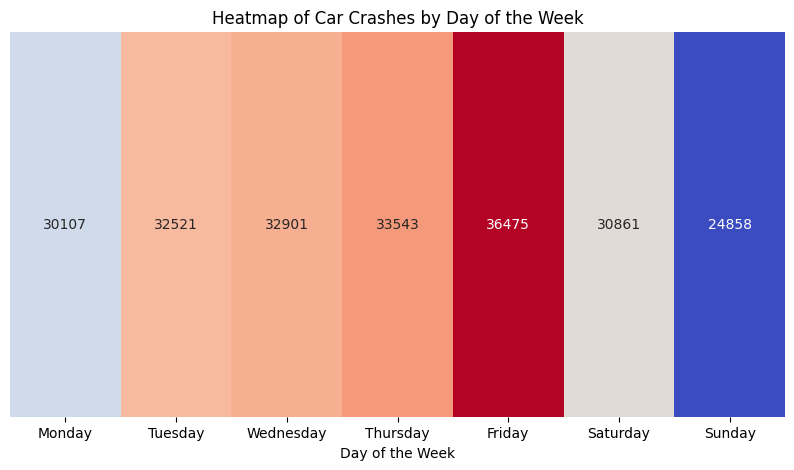

In [235]:
# Create Weekday Feature
df['Weekday'] = df['INCDATE'].dt.dayofweek

# Map integers to day names
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
crash_counts = df['Weekday'].value_counts().sort_index()  # Ensure proper order
crash_counts.index = [day_names[i] for i in crash_counts.index]  # Replace indices with names

# Create a heatmap
plt.figure(figsize=(10, 5))
sns.heatmap([crash_counts.values], cmap='coolwarm', annot=True, fmt='g', cbar=False)
plt.title('Heatmap of Car Crashes by Day of the Week')
plt.xlabel('Day of the Week')
plt.yticks([])  # Remove y-axis labels for single-row heatmap
plt.xticks(ticks=np.arange(7) + 0.5, labels=day_names, rotation=0)
plt.show()

During data cleaning, rows with unknown severity (class 0) were removed, and severe injury (class 2b) and fatal categories (class 3) were consolidated (shown in coding cell 2) into a single class (class 3 - severe) for better classification. Columns with over 10% missing values, non-predictive attributes, and those potentially leaking target information, such as the number of fatalities, were dropped. Categorical variables (such as WEATHER, ROADCOND, and LIGHTCOND) were processed using one-hot encoding and the rest of the categorical variables were processed with Label Encoding but not before dropping rows with null attributes.

In [236]:
# Remove rows with SEVERITYCODE = 0
df = df[df['SEVERITYCODE'] != 0]

# Remove columns with more than 10% missing values
threshold = len(df) * 0.9  # Keep columns with at least 90% non-missing values
columns_to_keep = df.columns[df.notnull().sum() >= threshold]
df = df[columns_to_keep]

# Remove descriptive or non-predictive columns
non_predictive_columns = [
    'X', 'Y', 'INCKEY', 'COLDETKEY',
    'OBJECTID', 'REPORTNO', 'INCDATE', 'INCDTTM', 'LOCATION',
    'EXCEPTRSNCODE', 'EXCEPTRSNDESC', 'STATUS', 'SDOT_COLDESC',
    'ST_COLDESC', 'INTKEY', 'SEVERITYDESC'
]
df = df.drop(columns=non_predictive_columns, errors='ignore')

# Drop columns that could 'leak' the target variable
df = df.drop(columns=["FATALITIES", "INJURIES", "SERIOUSINJURIES"])

# One-hot encode categorical variables (WEATHER, ROADCOND, LIGHTCOND)
categorical_columns = ['WEATHER', 'ROADCOND', 'LIGHTCOND']
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

# Drop null attributes
df = df.dropna()

# Label encode other categorical variables
label_encoder = LabelEncoder()
df['ADDRTYPE'] = label_encoder.fit_transform(df['ADDRTYPE'])
df['COLLISIONTYPE'] = label_encoder.fit_transform(df['COLLISIONTYPE'])
df['JUNCTIONTYPE'] = label_encoder.fit_transform(df['JUNCTIONTYPE'])
df['HITPARKEDCAR'] = label_encoder.fit_transform(df['HITPARKEDCAR'])
df['Season'] = label_encoder.fit_transform(df['Season'])

This is what our dataframe looks like right now after the data cleaning phase.

In [237]:
df

,ADDRTYPE,SEVERITYCODE,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,JUNCTIONTYPE,SDOT_COLCODE,INATTENTIONIND,UNDERINFL,SPEEDING,ST_COLCODE,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR,High_Risk_Driver,Environmental_Risk,Month,Season,Weekday,WEATHER_Blowing Snow,WEATHER_Clear,WEATHER_Fog/Smog/Smoke,WEATHER_Other,WEATHER_Overcast,WEATHER_Partly Cloudy,WEATHER_Raining,WEATHER_Severe Crosswind,WEATHER_Sleet/Hail/Freezing Rain,WEATHER_Snowing,WEATHER_Unknown,ROADCOND_Ice,ROADCOND_Oil,ROADCOND_Other,ROADCOND_Sand/Mud/Dirt,ROADCOND_Snow/Slush,ROADCOND_Standing Water,ROADCOND_Unknown,ROADCOND_Wet,LIGHTCOND_Dark - Street Lights Off,LIGHTCOND_Dark - Street Lights On,LIGHTCOND_Dark - Unknown Lighting,LIGHTCOND_Dawn,LIGHTCOND_Daylight,LIGHTCOND_Dusk,LIGHTCOND_Other,LIGHTCOND_Unknown
0,2,2.0,6,2,1,0,1,1,24.0,0,0,0,2,0,0,0,0,3.0,11,0,2,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
1,2,2.0,0,4,0,0,2,1,11.0,0,0,0,10,0,0,0,0,9.0,11,0,0,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False
2,1,1.0,9,4,0,0,3,4,14.0,0,0,0,11,0,0,0,0,3.0,2,3,3,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
3,2,1.0,3,2,0,0,2,1,11.0,0,0,0,28,0,0,0,0,9.0,6,2,1,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False
6,1,1.0,4,2,0,0,2,4,28.0,0,0,0,50,0,0,0,0,6.0,6,2,6,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221261,1,1.0,7,2,0,0,2,4,14.0,0,0,0,14,0,0,0,0,3.0,3,1,3,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False
221262,1,2.0,7,2,0,0,2,4,14.0,0,0,0,14,0,0,0,0,3.0,4,1,4,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
221263,2,1.0,8,2,0,0,2,1,11.0,0,0,0,16,0,0,0,0,3.0,5,1,3,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
221264,1,1.0,0,3,0,0,2,2,11.0,0,0,0,10,0,0,0,0,3.0,6,2,5,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False


We split the dataframe into X and y. We also label encode y so that it is ready to be passed into the mutual_info_classifier. The labels for y will be 0 (property damage), 1 (injury), 2 (severe) now.

In [238]:
# Split the Dataframe into X and y
X = df.drop(columns=["SEVERITYCODE"])
y = df["SEVERITYCODE"]

# Label encode the y variable. The labels are 0 (property damage), 1 (injury), 2 (severe) now
y = label_encoder.fit_transform(y)


Last stage of the data processing is Feature Selection. For feature selection, we used a two-phase approach: This involves using a mutual information classifier to rank features by their dependency on the target. Then we pass on a subset of these features (using a threshold) into the second phase, the Recursive Feature Elimination with Cross Validation.

Mutual information measures the amount of information one variable (e.g., a feature) provides about another variable (e.g., the target). It quantifies dependency between variables. If the mutual information is 0, the variables are completely independent. A higher mutual information score means that knowing the value of one variable reduces the uncertainty about the other.

In [239]:
# Retrieve the scores from the mutual_info_classif and sort them
mi_scores = mutual_info_classif(X, y)
mi_scores_sorted = sorted(zip(X.columns, mi_scores), key=lambda x: x[1], reverse=True)

Show the mutual information scores in order to determine a reasonable threshold so that only a subset of the features will be passed onto the next phase of the feature selection process. In this case, 0.002 was the threshold

In [240]:
mi_scores_sorted

[('ST_COLCODE', 0.13312250065355768),
 ('COLLISIONTYPE', 0.12680478347588475),
 ('SDOT_COLCODE', 0.09008608537189722),
 ('VEHCOUNT', 0.04997825723446003),
 ('PEDCOUNT', 0.037588478562638805),
 ('ADDRTYPE', 0.03441196073960473),
 ('JUNCTIONTYPE', 0.030667859277766274),
 ('PEDCYLCOUNT', 0.0231176144285008),
 ('PERSONCOUNT', 0.022562969960678858),
 ('LIGHTCOND_Daylight', 0.02104707345597312),
 ('WEATHER_Clear', 0.020882734153079063),
 ('CROSSWALKKEY', 0.016900553957924336),
 ('LIGHTCOND_Unknown', 0.012578701947875803),
 ('ROADCOND_Unknown', 0.012563571544883523),
 ('WEATHER_Unknown', 0.011984195814381371),
 ('SEGLANEKEY', 0.011429748310271437),
 ('High_Risk_Driver', 0.005990190633253789),
 ('HITPARKEDCAR', 0.005380205004348326),
 ('ROADCOND_Wet', 0.005118577200421415),
 ('Season', 0.005077310679226121),
 ('Weekday', 0.0047882890027370895),
 ('LIGHTCOND_Dark - Street Lights On', 0.004558853557487641),
 ('Environmental_Risk', 0.0044469244623779325),
 ('Month', 0.003809508169521525),
 ('SPEE

Show the features being passed to the second phase.

In [241]:
# Only keep the features that earned a score > 0.002
top_features_mi = [feature for feature, score in mi_scores_sorted[:] if score > 0.002]
X_mi_selected = X[top_features_mi]
X_mi_selected

,ST_COLCODE,COLLISIONTYPE,SDOT_COLCODE,VEHCOUNT,PEDCOUNT,ADDRTYPE,JUNCTIONTYPE,PEDCYLCOUNT,PERSONCOUNT,LIGHTCOND_Daylight,WEATHER_Clear,CROSSWALKKEY,LIGHTCOND_Unknown,ROADCOND_Unknown,WEATHER_Unknown,SEGLANEKEY,High_Risk_Driver,HITPARKEDCAR,ROADCOND_Wet,Season,Weekday,LIGHTCOND_Dark - Street Lights On,Environmental_Risk,Month,SPEEDING,INATTENTIONIND,LIGHTCOND_Dawn
0,2,6,24.0,1,1,2,1,0,2,True,True,0,False,False,False,0,0,0,False,0,2,False,3.0,11,0,0,False
1,10,0,11.0,2,0,2,1,0,4,False,False,0,False,False,False,0,0,0,True,0,0,True,9.0,11,0,0,False
2,11,9,14.0,3,0,1,4,0,4,True,True,0,False,False,False,0,0,0,False,3,3,False,3.0,2,0,0,False
3,28,3,11.0,2,0,2,1,0,2,False,False,0,False,False,False,0,0,0,True,2,1,True,9.0,6,0,0,False
6,50,4,28.0,2,0,1,4,0,2,False,True,0,False,False,False,0,0,0,False,2,6,True,6.0,6,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221261,14,7,14.0,2,0,1,4,0,2,True,False,0,False,True,True,0,0,0,False,1,3,False,3.0,3,0,0,False
221262,14,7,14.0,2,0,1,4,0,2,True,True,0,False,False,False,0,0,0,False,1,4,False,3.0,4,0,0,False
221263,16,8,11.0,2,0,2,1,0,2,True,True,0,False,False,False,0,0,0,False,1,3,False,3.0,5,0,0,False
221264,10,0,11.0,2,0,1,2,0,3,True,True,0,False,False,False,0,0,0,False,2,5,False,3.0,6,0,0,False


The RFECV removes less important features and optimizes model performance. This process improved accuracy and reduced overfitting by focusing on the most informative features. Through feature creation, data cleaning, and feature selection, we refined the dataset to build models that effectively predict accident severity and support emergency response decisions. We chose an XGBClassifier model as the estimator for the RFECV.

In [242]:
#Define XGBoost model (RFE needs an estimator)
xgb = XGBClassifier(random_state=42)

#Recursive Feature Elimination with Cross-Validation
#From the MI feature ranking, the best predictors are selected for the next stage of processing by RFE with crossvalidation. 
#The best feature subset identified from the first phase is given as the input for the second phase to filter the features with high relevance and correlation.
#The RFE method eliminates the less important features recursively for each iteration based on the decision scores returned by the classifier.

#Cross-validator
cv = StratifiedKFold(n_splits=5)

#step=1 is the number of features to remove each iteration
rfecv = RFECV(estimator=xgb, step=1, cv=cv, n_jobs=-1)
X_rfe_selected = rfecv.fit_transform(X_mi_selected, y)

selected_features_rfe = [top_features_mi[i] for i in range(len(rfecv.support_)) if rfecv.support_[i]]

# Print the number of selected features and the selected features
print(f"Optimal number of features: {rfecv.n_features_}")
print(f"Selected features: {selected_features_rfe}")

Optimal number of features: 20
Selected features: ['ST_COLCODE', 'COLLISIONTYPE', 'SDOT_COLCODE', 'VEHCOUNT', 'PEDCOUNT', 'ADDRTYPE', 'JUNCTIONTYPE', 'PEDCYLCOUNT', 'PERSONCOUNT', 'LIGHTCOND_Daylight', 'LIGHTCOND_Unknown', 'ROADCOND_Unknown', 'WEATHER_Unknown', 'High_Risk_Driver', 'HITPARKEDCAR', 'ROADCOND_Wet', 'LIGHTCOND_Dark - Street Lights On', 'SPEEDING', 'INATTENTIONIND', 'LIGHTCOND_Dawn']


Using heatmaps and intuition, there seems to be potential relations between the newly created features and the SEVERITYCODE. So add them to the selected features in case if they aren't added in the feature selection process (the RFECV selection process tends to identify different features at random as important).

In [243]:
X = X[selected_features_rfe]
X['High_Risk_Driver'] = df['High_Risk_Driver']
X['Environmental_Risk'] = df['Environmental_Risk']
X['Weekday'] = df['Weekday']
X['Season'] = df['Season']


Data is now ready to be passed to the models for training and testing

MODELLING AND ANALYSIS

In this analysis, the target variable is the severity of traffic collisions, with the goal of predicting whether an accident is property damage (1), injury (2), or severe (3) (although after label encoding the target variable, the labels are 0, 1, 2 respectively). To achieve this, we compare three machine learning models: Decision Tree, Random Forest, and Gradient Boosting. Each model uses the same set of predictors (weather, road surface conditions, etc). By analysing the performance of these models, we aim to identify the most effective technique for accurately predicting accident severity and informing traffic safety initiatives.

For our analysis, we split the dataset using the standard train-test split approach, allocating 90% of the data for training and reserving the remaining 10% for testing. This strategy proved effective given the large size of the dataset, ensuring the test set remained representative while providing sufficient data for training the models.

In [244]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

Decision Tree Model

For the Decision Tree model, we used the CART framework, a non-parametric method that splits data iteratively to maximize information gain. Its simplicity and interpretability highlight key features driving accident severity predictions. GridSearchCV (5-fold) was used to optimize hyperparameters like max_depth, min_samples_leaf, and min_samples_split.

In [245]:
#Hyper-parameter Tuning
cv = StratifiedKFold(n_splits=5)

# Define the parameter grid
param_grid = {
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10]
}

# Define Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Perform grid-search to find best hyperparameters
grid_search = GridSearchCV(estimator=dt_classifier, param_grid=param_grid, cv=cv, scoring='accuracy', verbose=2)
grid_search.fit(X_train, y_train)

# Print best hyperparameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=5; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=5; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=5; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=5; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=5; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=10; total time=   0.1s
[CV] END max_depth=5, min_samples_l

Best Hyperparameters Identified:

max_depth: 10

min_samples_leaf: 10

min_samples_split: 2

In [246]:
# Define Decision Tree classifier with best hyperparameters
dt_classifier = DecisionTreeClassifier(random_state=42, criterion='entropy', max_depth=10, min_samples_leaf=10, min_samples_split=2)

# Train the classifier
dt_classifier.fit(X_train, y_train)

# Export the tree for visualisation
tree = export_graphviz(dt_classifier, out_file='tree.dot', feature_names=X.columns, filled=True, rounded=True, special_characters=True)
graphviz.Source(tree)

# Make predictions on the test set
y_pred_dt = dt_classifier.predict(X_test)
graph = graphviz.Source.from_file('tree.dot')
graph.view()

'tree.dot.pdf'

Random Forest

For the Random Forest model, we applied Bayesian Optimization with BayesSearchCV for efficient hyperparameter selection. Unlike Grid Search, Bayesian Optimization focuses on promising areas in the parameter space, saving computational resources while achieving high accuracy. A 3-fold cross-validation ensured the model's generalizability to unseen data, with accuracy as the primary metric.

In [247]:
# Define the model
rf = RandomForestClassifier(random_state=42)

# Set up the parameter space for Bayesian Optimization
param_space = {
    'n_estimators': (50, 500),  # Number of trees in the forest
    'max_depth': (10, 20),   # Maximum depth of the tree
    'max_features': (5, 10)  # Number of features to consider for the best split
}

# Perform Bayesian Optimization using `BayesSearchCV`
optimizer = BayesSearchCV(
    estimator=rf,
    search_spaces=param_space,
    n_iter=50,  # Number of iterations
    cv=3,       # Number of cross-validation folds
    scoring='accuracy'  # Use accuracy as scoring metric
)

# Fit the optimizer on the training data
optimizer.fit(X_train, y_train)

# Get the best parameters
best_params = optimizer.best_params_
score = optimizer.score
print("Best parameters found:", best_params)
print("Best score:", score)

Best parameters found: OrderedDict({'max_depth': 12, 'max_features': 10, 'n_estimators': 482})
Best score: <bound method BaseSearchCV.score of BayesSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
              scoring='accuracy',
              search_spaces={'max_depth': (10, 20), 'max_features': (5, 10),
                             'n_estimators': (50, 500)})>


Best Hyperparameters Identified:

n_estimators: 482

max_depth: 12

max_features: 10

Additional parameters included class_weight = 'balanced' to handle class imbalance and min_samples_split = 1000 to prevent overfitting.

In [249]:
# Train the model with the best hyperparameters
rf = RandomForestClassifier(max_depth=12, max_features=10, n_estimators=482, min_samples_split=1000, class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf.predict(X_test)

Gradient Boosting Model

Gradient Boosting was our third model, chosen for its ability to handle complex data relationships through iterative improvements in prediction accuracy. We used Random Search to identify the best hyperparameters. This method allowed us to efficiently explore the parameter space without assumptions about the underlying model, complementing the systematic approaches used for the other models.

In [ ]:
#Hyper-parameter Tuning
cv = StratifiedKFold(n_splits=5)

# Define the parameter grid
param_grid = {
    'max_depth': [2, 5, 10],
    'learning_rate': [0.01, 0.05, 0.01],
    'n_estimators': [10, 50, 100]
}

# Define standard Gradient Boosting Model
gb_classifier = GradientBoostingClassifier(random_state=42)

# Perform random search to find best hyperparameters
random_search = RandomizedSearchCV(estimator=gb_classifier, param_distributions=param_grid, cv=cv, scoring='accuracy', verbose=2, n_jobs=-1)
random_search.fit(X_train, y_train)

# Print out best hyperparameters with best score
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.05}
Best Score: 0.7406921668168901


Best Hyperparameters Identified:

max_depth: 5

learning_rate: 0.05

n_estimators: 100

In [250]:
# Define Gradient Boosting Model with best hyperparameters
gb_model = GradientBoostingClassifier(max_depth=5, learning_rate=0.05, n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)

# Predict on the test set
y_pred_gb = gb_model.predict(X_test)

MODEL EVALUATIONS

To evaluate model performance, we utilized a variety of metrics, including Accuracy, Precision, Recall, and F1-score. These metrics provided a comprehensive assessment of each model's performance, balancing overall correctness with the ability to identify classes effectively.

Decision Tree

In [251]:
print("Decision Tree Model:\n")

# Show Confusion Matrix for Decision Tree Model
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))

Decision Tree Model:

Confusion Matrix:
 [[11546   974     0]
 [ 3492  2119     2]
 [  131   200     1]]


The Decision Tree model excelled in predicting property damage cases (class 0 after label encoding) but struggled with injury (class 1 after label encoding) and severe cases (class 2 after label encoding), as seen in the high misclassification rates for these classes.

Random Forest

In [252]:
print("Random Forest Evaluation")

# Show Confusion Matrix for Random Forest Model
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

Random Forest Evaluation
Confusion Matrix:
 [[7430 4079 1011]
 [ 920 3154 1539]
 [  33   95  204]]


The Random Forest model distributed errors more evenly but performed poorly in classifying property damage cases, misclassifying many as injuries or severe cases.

Gradient Boosting

In [253]:
print("Gradient Boosting Model:")

# Show Confusion Matrix for Gradient Boosting Model
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_gb))

Gradient Boosting Model:
Confusion Matrix:
 [[11735   784     1]
 [ 3661  1950     2]
 [  128   202     2]]


The Gradient Boosting model showed similar strengths to the Decision Tree in class 0 and class 1 predictions, with fewer misclassifications overall, but it struggled slightly with severe cases, misclassifying most as injuries.

Model Comparisons

Decision Tree

In [254]:
# Provide accuracy and classification report for Decision Tree
print("Decision Tree Model:\n")
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("\nClassification Report:\n", classification_report(y_test, y_pred_dt, zero_division=0))

# Perform Cross-Validation for Decision Tree
cv_scores = cross_val_score(dt_classifier, X, y, cv=cv, scoring='accuracy')
print("\nCross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", np.mean(cv_scores))

Decision Tree Model:

Accuracy: 0.7401028973734092

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.92      0.83     12520
           1       0.64      0.38      0.48      5613
           2       0.33      0.00      0.01       332

    accuracy                           0.74     18465
   macro avg       0.58      0.43      0.44     18465
weighted avg       0.72      0.74      0.71     18465


Cross-Validation Scores: [0.72967045 0.73922933 0.74149697 0.73832864 0.73843696]
Mean CV Accuracy: 0.7374324691303041


Random Forest

In [255]:
# Provide accuracy and classification report for Random Forest
print("\nRandom Forest Model:\n")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf, zero_division=0))

# Perform Cross-Validation for Random Forest
cv_scores = cross_val_score(rf, X, y, cv=cv, scoring='accuracy')
print("\nCross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", np.mean(cv_scores))


Random Forest Model:

Accuracy: 0.5842404549147034

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.59      0.71     12520
           1       0.43      0.56      0.49      5613
           2       0.07      0.61      0.13       332

    accuracy                           0.58     18465
   macro avg       0.46      0.59      0.44     18465
weighted avg       0.73      0.58      0.63     18465


Cross-Validation Scores: [0.60017872 0.59896017 0.56940533 0.57365685 0.55099112]
Mean CV Accuracy: 0.5786384362061952


Gradient Boosting

In [256]:
# Provide accuracy and classification report for Gradient Boosting
print("Gradient Boosting Model:\n")
print("Accuracy:", accuracy_score(y_test, y_pred_gb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_gb, zero_division=0))

# Perform Cross-Validation for Gradient Boosting
cv_scores = cross_val_score(gb_model, X, y, cv=cv, scoring='accuracy')
print("\nCross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", np.mean(cv_scores))

Gradient Boosting Model:

Accuracy: 0.7412401841321419

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.94      0.84     12520
           1       0.66      0.35      0.46      5613
           2       0.40      0.01      0.01       332

    accuracy                           0.74     18465
   macro avg       0.61      0.43      0.43     18465
weighted avg       0.72      0.74      0.71     18465


Cross-Validation Scores: [0.73178261 0.74239757 0.746263   0.73905979 0.73873484]
Mean CV Accuracy: 0.7396475618490923


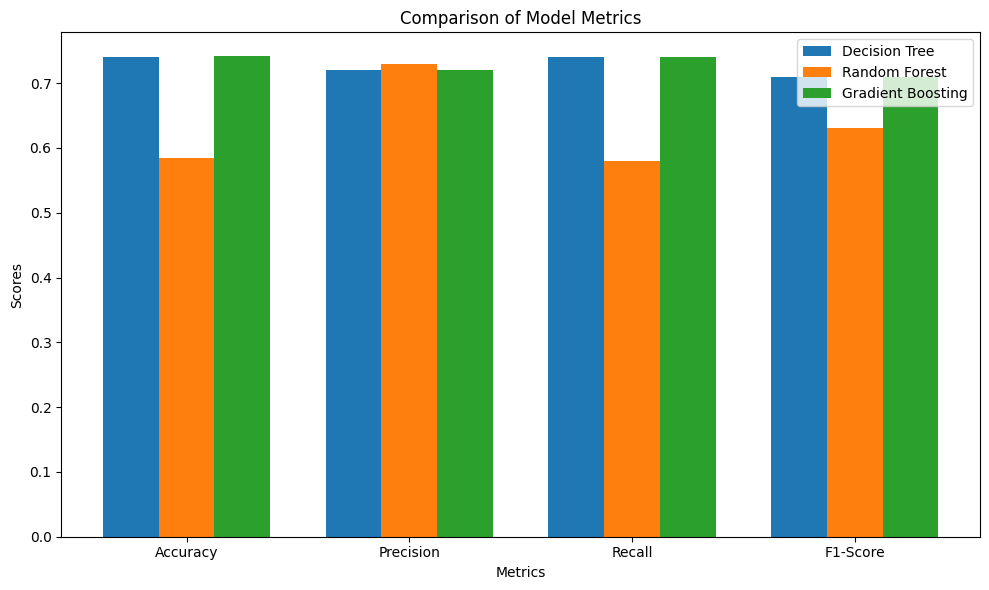

In [257]:
# Model metrics
metrics = {
    "Decision Tree": {"Accuracy": 0.7403, "Precision": 0.72, "Recall": 0.74, "F1-Score": 0.71},
    "Random Forest": {"Accuracy": 0.5846, "Precision": 0.73, "Recall": 0.58, "F1-Score": 0.63},
    "Gradient Boosting": {"Accuracy": 0.7413, "Precision": 0.72, "Recall": 0.74, "F1-Score": 0.71},
}

# Extract metric values
models = list(metrics.keys())
metric_names = list(metrics["Decision Tree"].keys())
values = np.array([[metrics[model][metric] for metric in metric_names] for model in models])

# Plot grouped bar chart
x = np.arange(len(metric_names))
bar_width = 0.25
plt.figure(figsize=(10, 6))

for i, model in enumerate(models):
    plt.bar(x + i * bar_width, values[i], width=bar_width, label=model)

plt.xticks(x + bar_width, metric_names)
plt.xlabel("Metrics")
plt.ylabel("Scores")
plt.title("Comparison of Model Metrics")
plt.legend()
plt.tight_layout()
plt.show()

As shown in Histogram above, among the three models, Gradient Boosting emerged as the most robust, achieving the highest accuracy of 74.13% and a balanced recall of 74%. It matched the Decision Tree in weighted F1-score (0.71) but demonstrated greater consistency, with cross-validation scores averaging 73.95%. The Decision Tree also performed well, with a comparable accuracy of 74.03% and strong recall for property damage cases (93%). However, it struggled significantly with injury cases (recall: 36%) and performed poorly on severe cases, highlighting limitations in handling minority classes. In contrast, the Random Forest model lagged behind, achieving the lowest accuracy at 58.42%. While it excelled in precision (73%), indicating reliability in predictions, it suffered from low recall (59%), particularly for injury and severe cases. Its weighted F1-score of 0.63 reflects this trade-off, making it the least effective model overall. The Gradient Boosting model’s balance of precision, recall, and consistency solidified its position as the best performer.

In conclusion, we tested various models, but none outperformed the Gradient Boosting model. While the Decision Tree and Random Forest models excelled in certain areas like recall and precision, respectively, Gradient Boosting provided the best overall performance with balanced recall, consistent accuracy, and reliability.